# Optimal Growth Model with Policy Function Iteration using Julia

In [1]:
using BenchmarkTools
using Plots

In [2]:
mutable struct Model
    # primitive parameter
    beta::Float64 #subjective discount factor
    sigma::Float64 # relative risk aversion
    delta::Float64 #depriciation rate
    alpha::Float64 # capital share

    # discretize asset space
    agrid::Array{Float64,1}
end


# working like np.argmax(matrix,axis=1)
function argmax(mat::Array{Float64,2})
    values, indices = findmax(mat,2)
    return ind2sub(size(mat),vec(indices))[2]
end

function PFI(m::Model)
    beta = m.beta
    sigma = m.sigma
    alpha = m.alpha
    delta = m.delta
    
    agrid =m.agrid
    const na = size(agrid, 1)
    
    #utility function
    u(c::Float64) = (c^(1-sigma))/(1-sigma)
    
    const penalty = -999999999.9
    
    #initialize value function and so on
    v  = zeros(na,na) # temp value function

    util = zeros(na,na) # utility matrix
    reward = zeros(na,1) # new utility using policy
    v0 = zeros(na,1) # initial guess of value function
    Tv = zeros(na,1) # update value function
    pol_a =zeros(na,1) # policy function
    
    I  = speye(na) # create sparse identity matrix
    
    
    #create consuption and utility matrix        
    c=0.0
    for (i,today) in enumerate(agrid)
        for (j,next) in enumerate(agrid)
            @inbounds c = today ^ alpha + (1-delta)*today - next
            @inbounds util[i,j] = u(c)
            if c <= 0.0
                @inbounds util[i,j] = penalty
            end
        end
    end

    #iteration settings
    const maxiter = 1000
    const tol =1e-5
    error = 10.0

    # Policy function iteration
    for it in 1 : maxiter
        # calculate temp value function
        for j in 1:na
            for i in 1:na
                @inbounds v[i,j] = util[i,j] + beta*v0[j]
            end
        end
        
        a_index = argmax(v) # obtain policy function ver. index
        
        for i in 1:na
             @inbounds pol_a[i]   = agrid[a_index[i]]
             @inbounds reward[i] = u(agrid[i]^alpha + (1-delta)*agrid[i] - pol_a[i]) 
        end
        
        Q = spzeros(na,na)
        for i in 1: na
            Q[i,a_index[i]] = 1 
        end 
        
        Tv = (I-beta*Q)\reward
        
        error = maximum(abs.(Tv-v0)) # update error
        v0    = copy(Tv) # update value function
        
        if error < tol
            break
        end
    end
    
    return(agrid,v0,pol_a)
end

PFI (generic function with 1 method)

In [3]:
beta = 0.95 #subjective discount factor
sigma = 2.0 # relative risk aversion
delta = 0.1 #depriciation rate
alpha = 0.33 # capital share

# Steady state
aterm = 1.0/beta -(1.0 -delta)
kstar = alpha/aterm
kstar = kstar^(1.0/(1.0-alpha))

amin = 0.1 * kstar
amax = 2.0 * kstar
na   = 250

model = Model(beta, sigma, delta, alpha, linspace(amin, amax, na))

Model(0.95, 2.0, 0.1, 0.33, [0.316086, 0.340205, 0.364324, 0.388443, 0.412562, 0.436681, 0.4608, 0.484919, 0.509038, 0.533157  …  6.10465, 6.12877, 6.15289, 6.17701, 6.20113, 6.22524, 6.24936, 6.27348, 6.2976, 6.32172])

In [4]:
@time agrid,v0,pol_a = PFI(model)

  0.985732 seconds (669.28 k allocations: 38.043 MiB, 0.61% gc time)


([0.316086, 0.340205, 0.364324, 0.388443, 0.412562, 0.436681, 0.4608, 0.484919, 0.509038, 0.533157  …  6.10465, 6.12877, 6.15289, 6.17701, 6.20113, 6.22524, 6.24936, 6.27348, 6.2976, 6.32172], [-22.9351; -22.7698; … ; -15.6819; -15.672], [0.484919; 0.509038; … ; 5.95994; 5.95994])


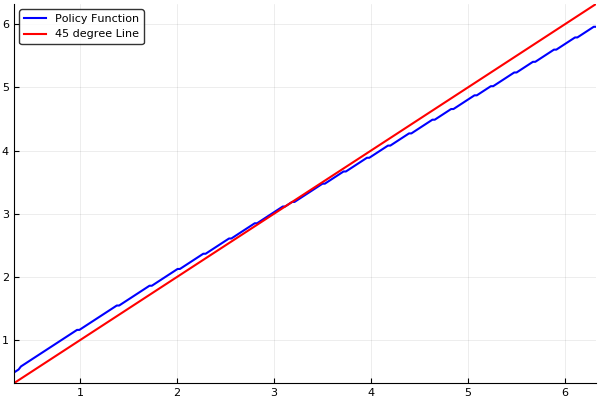

In [5]:
plot(agrid,pol_a ,color="blue", linewidth=1.5, label="Policy Function")
plot!(agrid,agrid, color="red", linewidth=1.5, label="45 degree Line")


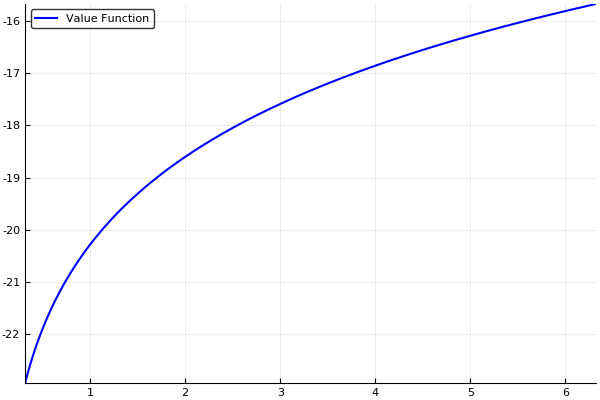

In [6]:
plot(agrid,v0,color="blue",linewidth=1.5, label="Value Function")

In [7]:
@benchmark PFI(model)

BenchmarkTools.Trial: 
  memory estimate:  3.85 MiB
  allocs estimate:  1850
  --------------
  minimum time:     9.373 ms (0.00% GC)
  median time:      9.711 ms (0.00% GC)
  mean time:        9.994 ms (2.06% GC)
  maximum time:     12.693 ms (8.75% GC)
  --------------
  samples:          500
  evals/sample:     1